## Importing the required Packages.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix, recall_score,precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE




data = pd.read_excel('trial1.xls',skipinitialspace=True)
print("The shape of data is :",data.shape)
data.head()

The shape of data is : (1200, 28)


,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,...,4,10,2,2,10,7,0,8,No,3
1,E1001006,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,...,4,20,2,3,7,7,1,7,No,3
2,E1001007,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,...,3,20,2,3,18,13,1,12,No,4
3,E1001009,41,Male,Human Resources,Divorced,Human Resources,Manager,Travel_Rarely,10,4,...,2,23,2,2,21,6,12,6,No,3
4,E1001010,60,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,16,4,...,4,10,1,3,2,2,2,2,No,3


### Checking the missing values.

In [8]:
print(data.isnull().sum().sum())
print(data.duplicated().sum())

0
0


### Visual Representation of Departmentwise performance for the Company performance overview.

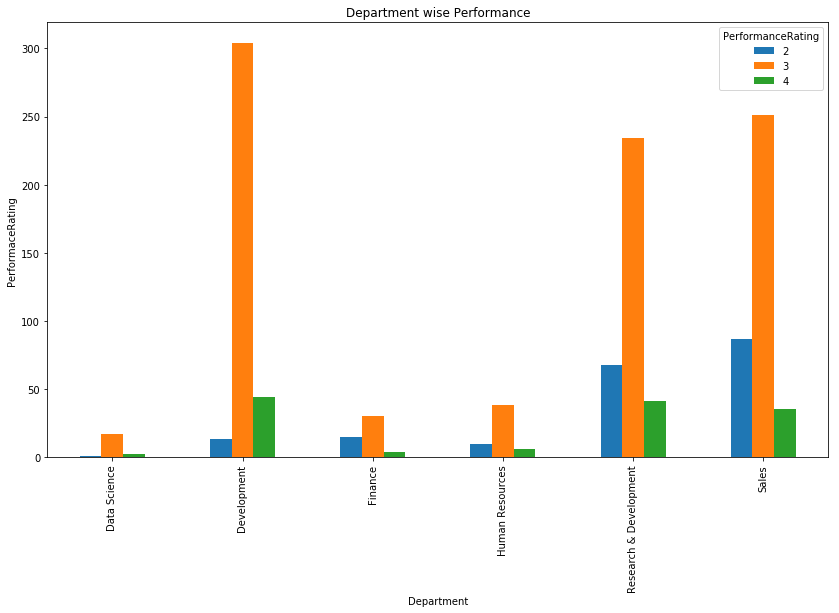

In [9]:
pd.crosstab(data.EmpDepartment,data.PerformanceRating).plot(kind='bar',figsize=(14,8))
plt.title('Department wise Performance')
plt.xlabel('Department')
plt.ylabel('PerformaceRating')
plt.show()

### Inspecting whether the data is normalised.

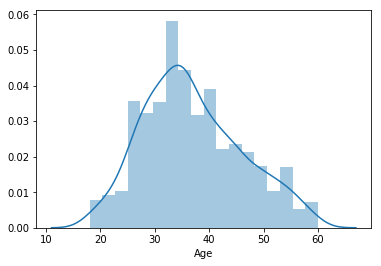

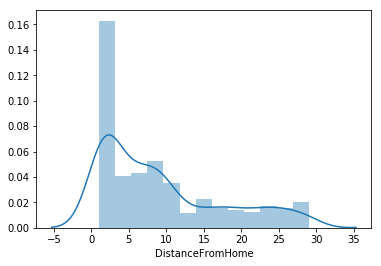

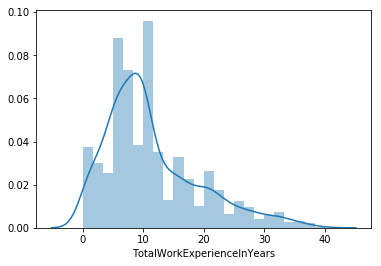

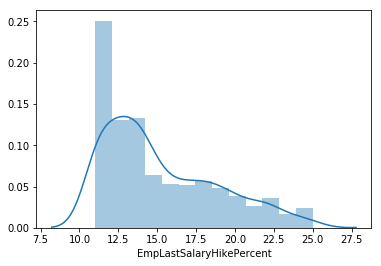

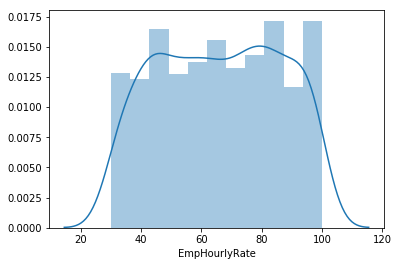

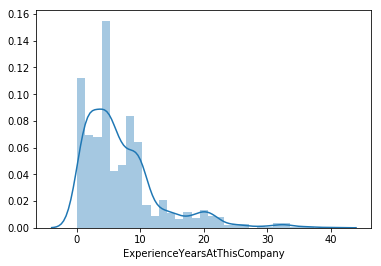

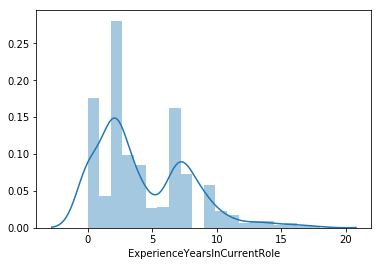

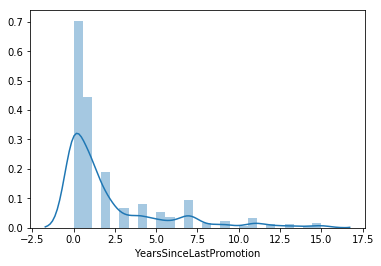

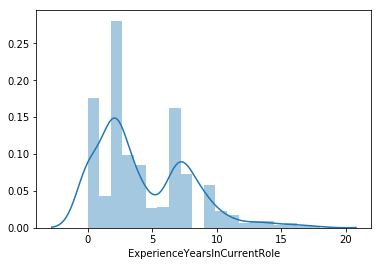

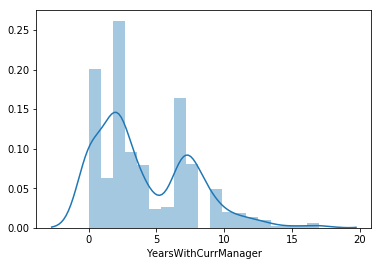

In [10]:
sns.distplot(data['Age']);
plt.show()
sns.distplot(data['DistanceFromHome']);
plt.show()
sns.distplot(data['TotalWorkExperienceInYears']);
plt.show()
sns.distplot(data['EmpLastSalaryHikePercent']);
plt.show()
sns.distplot(data['EmpHourlyRate']);
plt.show()
sns.distplot(data['ExperienceYearsAtThisCompany']);
plt.show()
sns.distplot(data['ExperienceYearsInCurrentRole']);
plt.show()
sns.distplot(data['YearsSinceLastPromotion']);
plt.show()
sns.distplot(data['ExperienceYearsInCurrentRole']);
plt.show()
sns.distplot(data['YearsWithCurrManager']);
plt.show()

### Creating a Function for measuring of abnormal skewness and kurtosis.

In [11]:
def skew_and_kurtosis(x):
    dict_skew=dict(x.skew())
    dict_kurt=dict(x.kurtosis())
    dict_fail1= dict()
    dict_fail2=dict()
    for key,values in dict_skew.items():
        if (-1<=values<=1):
            continue
        else:
            dict_fail1[key]=values
    for key,values in dict_kurt.items():
        if (-1<=values<=1):
            continue
        else:
            dict_fail2[key]=values
    
    
    for key in dict_fail2:
        if key in dict_fail1:
            print(key,dict_fail2[key])

In [12]:
skew_and_kurtosis(data._get_numeric_data())

ExperienceYearsAtThisCompany 4.057959404441291
YearsSinceLastPromotion 3.5390800793468817


### Identifying patterns for correlation from the whole dataset.

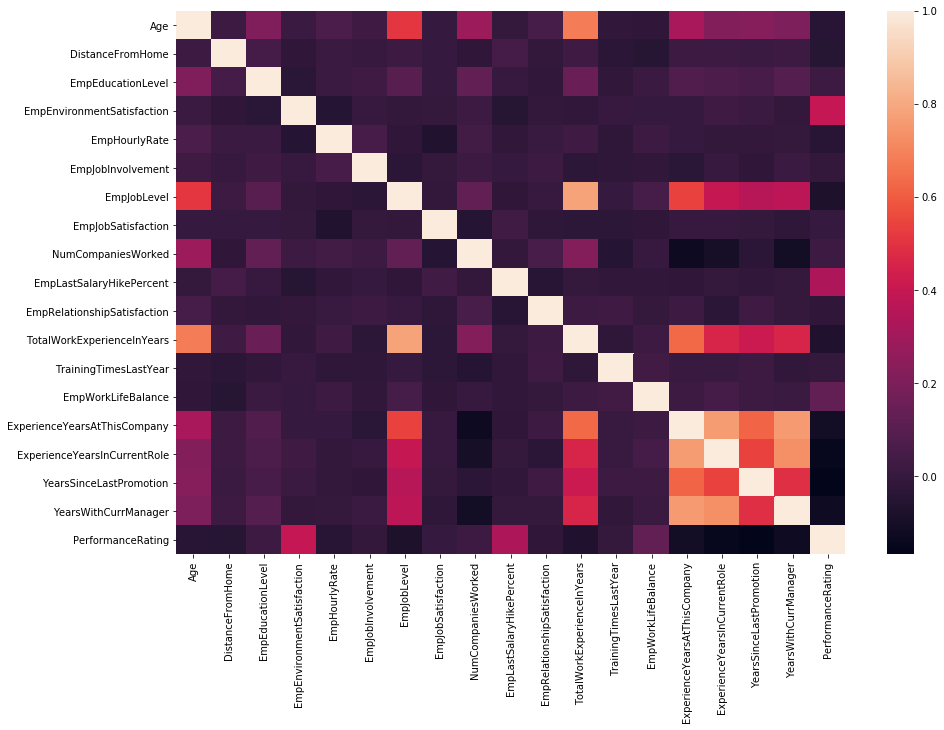

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr());

### Slicing the dataset and allocating them into variables for fitting them into models.

In [14]:
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]

### Identifying the main 5 features which are important to consider for further calculations in the model algorithm.

In [15]:
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X._get_numeric_data(),y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(5,'Score'))  #print 5 best features

                      Features       Score
9   EmpEnvironmentSatisfaction  297.136917
16    EmpLastSalaryHikePercent  238.004284
14          NumCompaniesWorked  133.602068
15                    OverTime  120.860036
3                MaritalStatus  110.691319


In [39]:
Counter(data.EmpDepartment)

Counter({'Sales': 373,
         'Human Resources': 54,
         'Development': 361,
         'Data Science': 20,
         'Research & Development': 343,
         'Finance': 49})

In [40]:
sales = data[data.EmpDepartment == 'Sales'] 
hr = data[data.EmpDepartment == 'Human Resources'] 
development = data[data.EmpDepartment == 'Development'] 
ds = data[data.EmpDepartment == 'Data Science'] 
rd = data[data.EmpDepartment == 'Research & Development'] 
finance = data[data.EmpDepartment == 'Finance'] 

In [22]:
sales

,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,...,4,10,2,2,10,7,0,8,No,3
1,E1001006,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,...,4,20,2,3,7,7,1,7,No,3
2,E1001007,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,...,3,20,2,3,18,13,1,12,No,4
4,E1001010,60,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,16,4,...,4,10,1,3,2,2,2,2,No,3
6,E1001016,50,Male,Marketing,Married,Sales,Sales Representative,Travel_Rarely,8,4,...,4,4,2,3,2,2,2,2,No,3
11,E1001024,47,Female,Medical,Divorced,Sales,Sales Executive,Travel_Frequently,3,3,...,4,28,2,2,22,2,11,13,No,3
12,E1001025,30,Male,Marketing,Divorced,Sales,Sales Executive,Travel_Rarely,27,5,...,4,10,2,2,8,7,7,7,No,4
13,E1001027,29,Male,Life Sciences,Single,Sales,Sales Representative,Travel_Rarely,10,3,...,3,1,6,3,1,0,0,0,No,3
20,E1001044,29,Male,Marketing,Divorced,Sales,Sales Representative,Travel_Rarely,10,3,...,4,2,2,3,2,2,2,2,No,3
25,E1001054,52,Male,Marketing,Married,Sales,Manager,Travel_Rarely,3,4,...,1,34,3,4,34,6,1,16,No,4


# Exploratory Data Analysis

Text(0.5, 1.0, 'Sales Department')

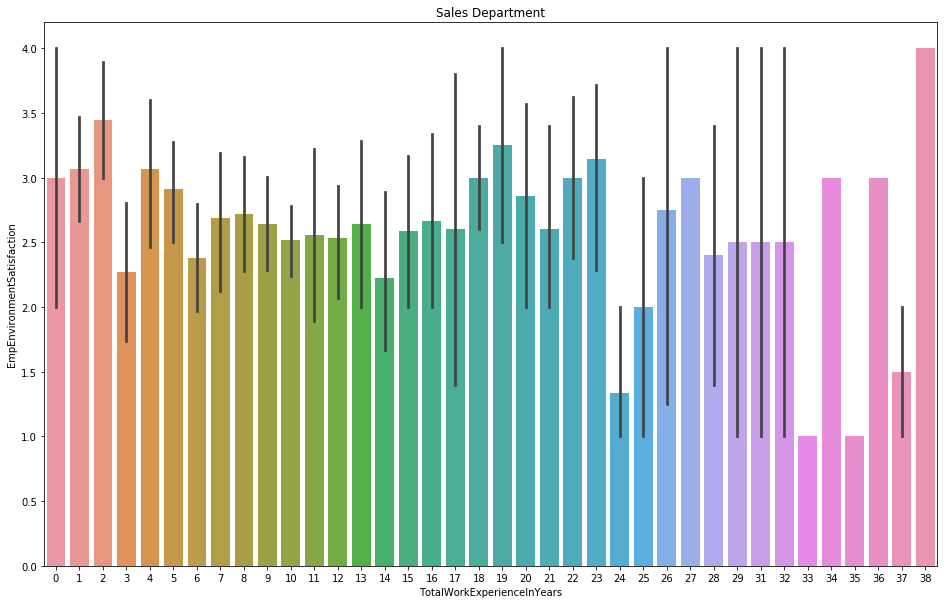

In [69]:
fig=plt.figure(figsize=(16,10))
sns.barplot(sales.TotalWorkExperienceInYears,sales.EmpEnvironmentSatisfaction,);
plt.title('Sales Department')

Text(0.5, 1.0, 'Sales Department')

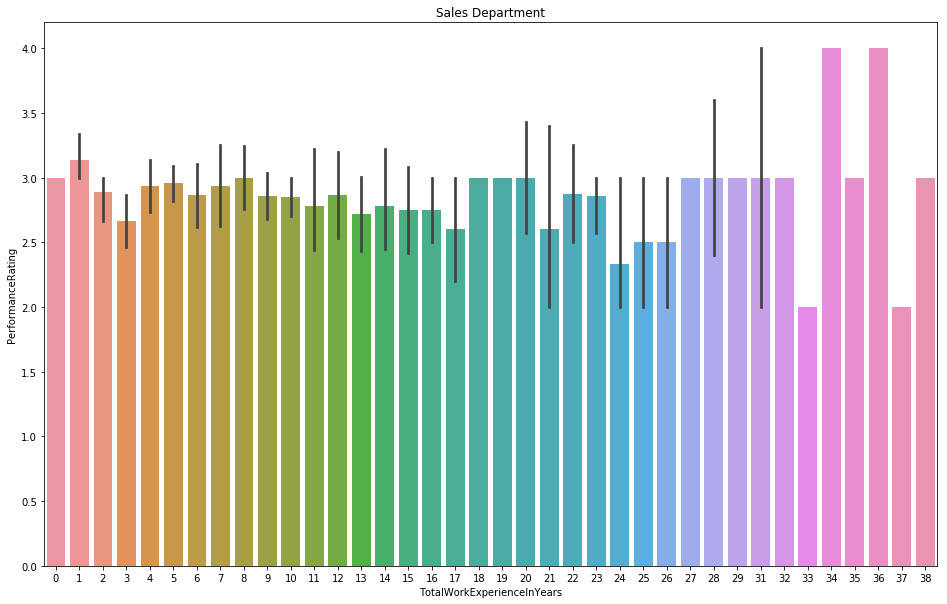

In [70]:
fig=plt.figure(figsize=(16,10))
sns.barplot(sales.TotalWorkExperienceInYears,sales.PerformanceRating);
plt.title('Sales Department')

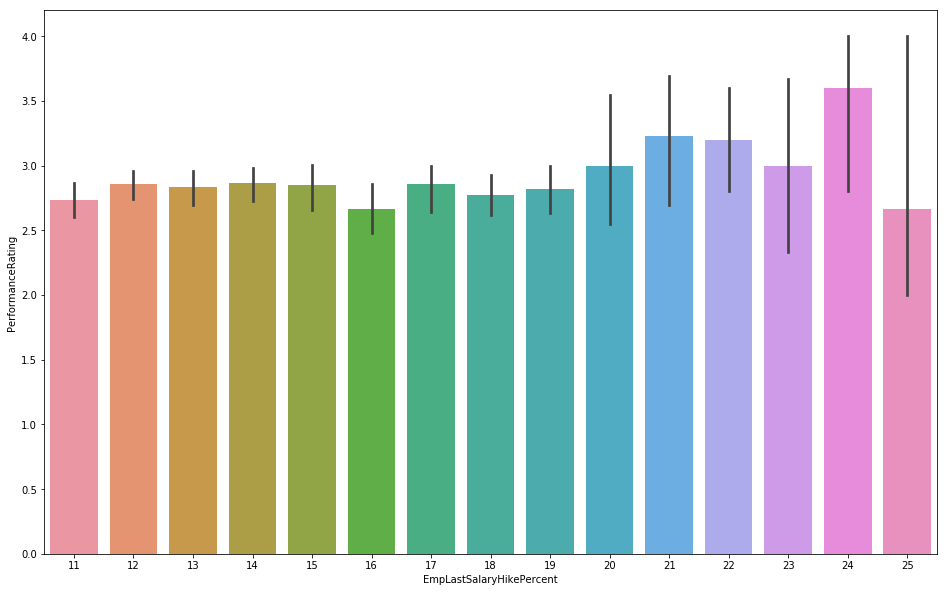

In [51]:
fig=plt.figure(figsize=(16,10))
sns.barplot(sales.EmpLastSalaryHikePercent,sales.PerformanceRating);

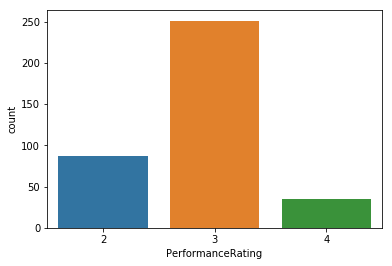

In [42]:
sns.countplot(sales.PerformanceRating);

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'HR Department')

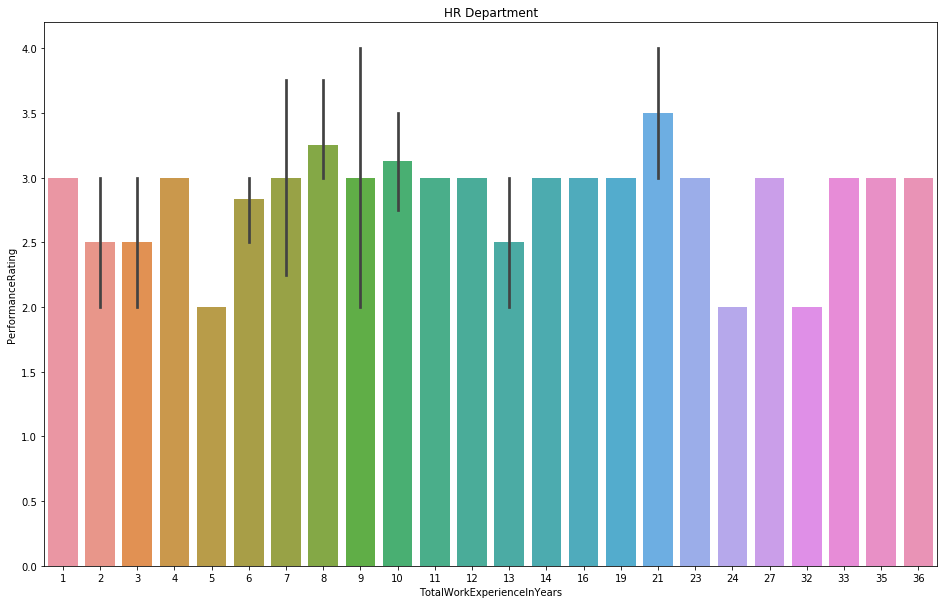

In [71]:
fig=plt.figure(figsize=(16,10))
print(sns.barplot(hr.TotalWorkExperienceInYears,hr.PerformanceRating))
plt.title('HR Department')

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'HR Department')

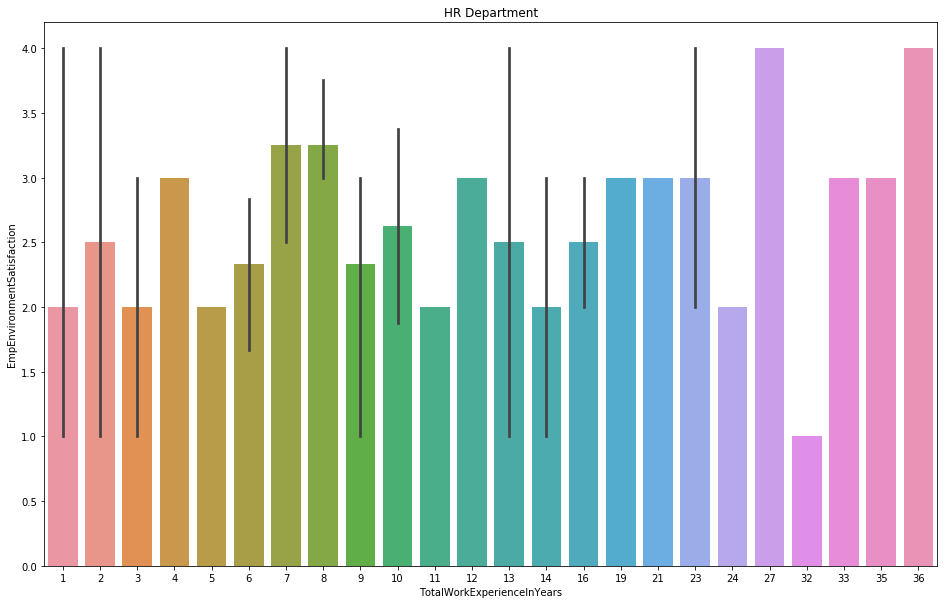

In [72]:
fig=plt.figure(figsize=(16,10))
print(sns.barplot(hr.TotalWorkExperienceInYears,hr.EmpEnvironmentSatisfaction,))
plt.title('HR Department')

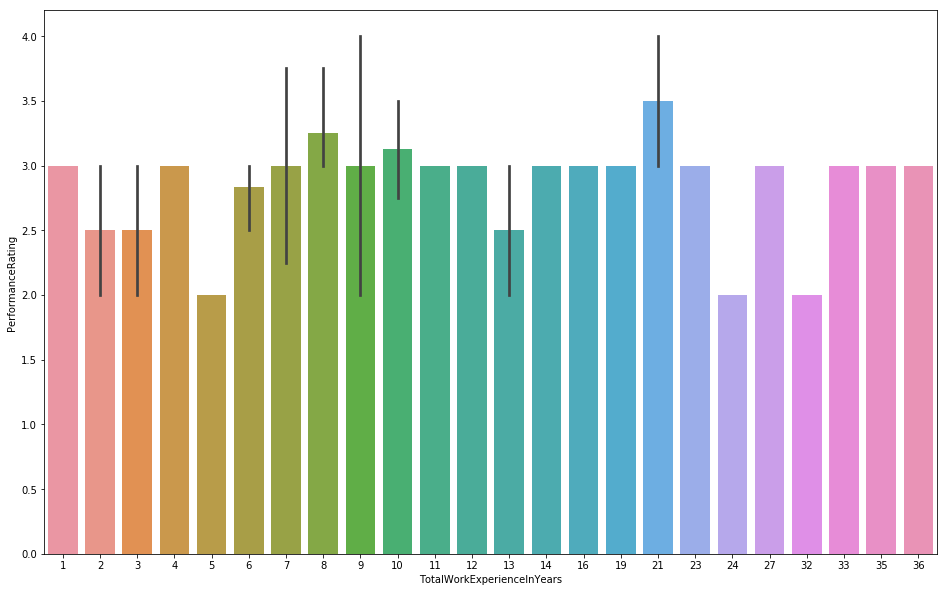

In [49]:
fig=plt.figure(figsize=(16,10))
sns.barplot(hr.TotalWorkExperienceInYears,hr.PerformanceRating);

Text(0.5, 1.0, 'HR Department')

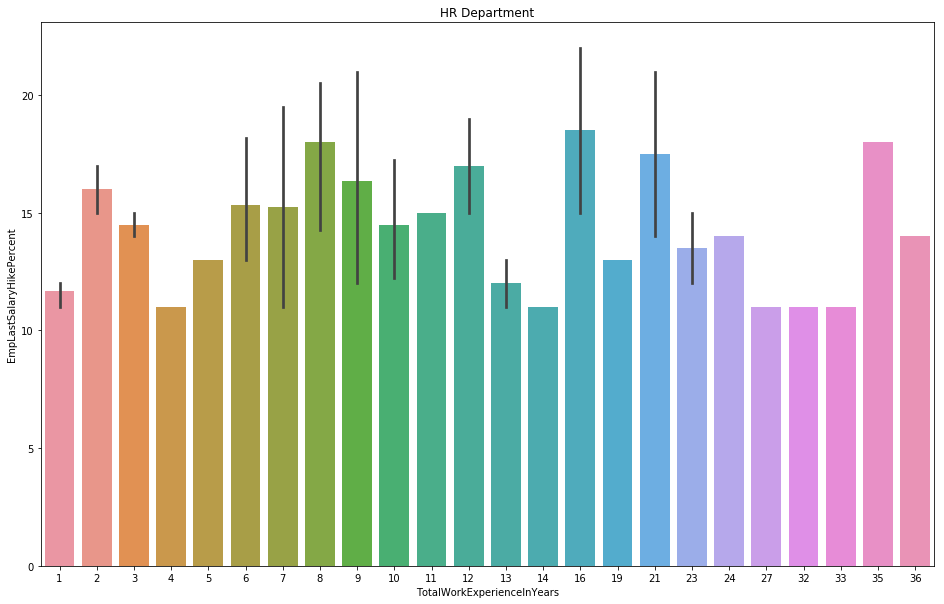

In [73]:
fig=plt.figure(figsize=(16,10))
sns.barplot(hr.TotalWorkExperienceInYears,hr.EmpLastSalaryHikePercent);
plt.title('HR Department')

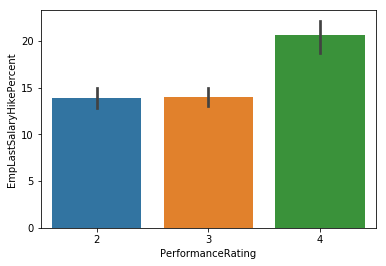

In [55]:
sns.barplot(hr.PerformanceRating,hr.EmpLastSalaryHikePercent);

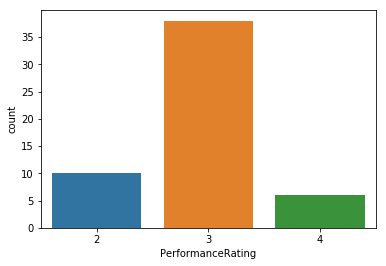

In [50]:
sns.countplot(hr.PerformanceRating);

Text(0.5, 1.0, 'Development Department')

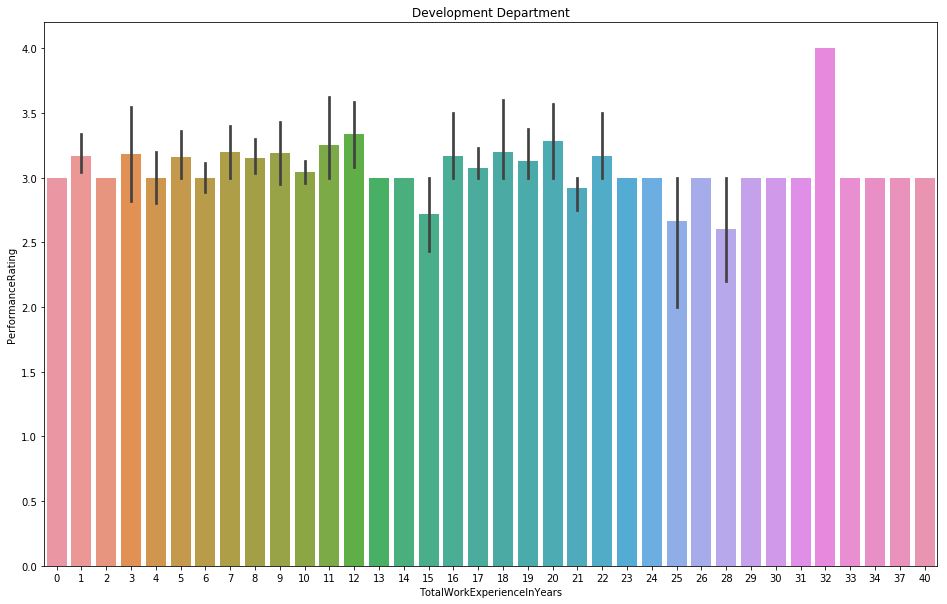

In [68]:
fig=plt.figure(figsize=(16,10))
sns.barplot(development.TotalWorkExperienceInYears,development.PerformanceRating);
plt.title('Development Department')

Text(0.5, 1.0, 'Development Department')

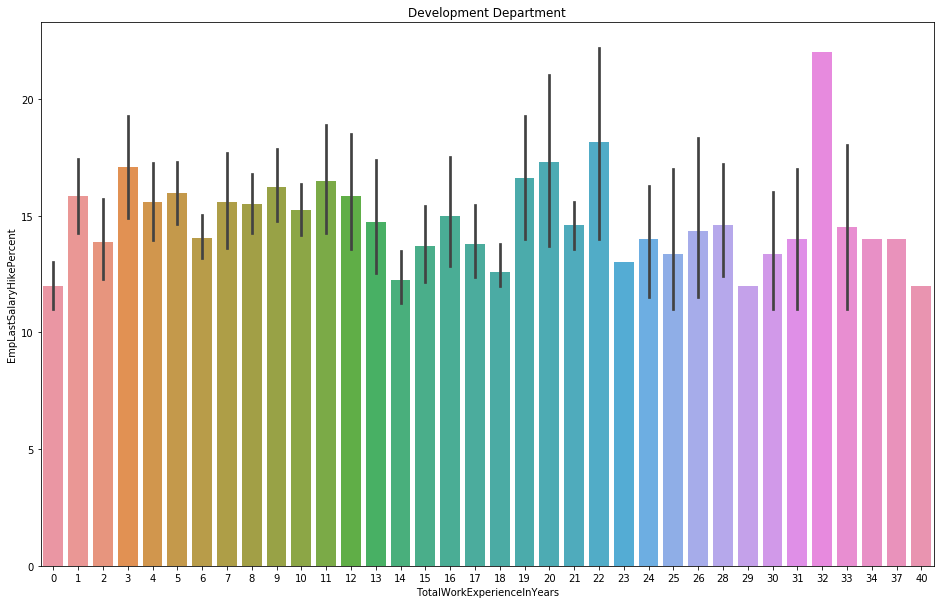

In [74]:
fig=plt.figure(figsize=(16,10))
sns.barplot(development.TotalWorkExperienceInYears,development.EmpLastSalaryHikePercent);
plt.title('Development Department')

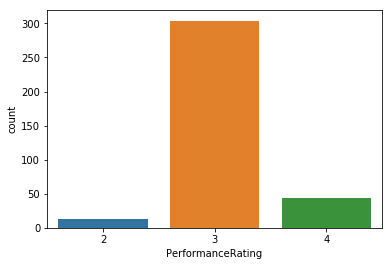

In [59]:
sns.countplot(development.PerformanceRating);

Text(0.5, 1.0, 'R&D Department')

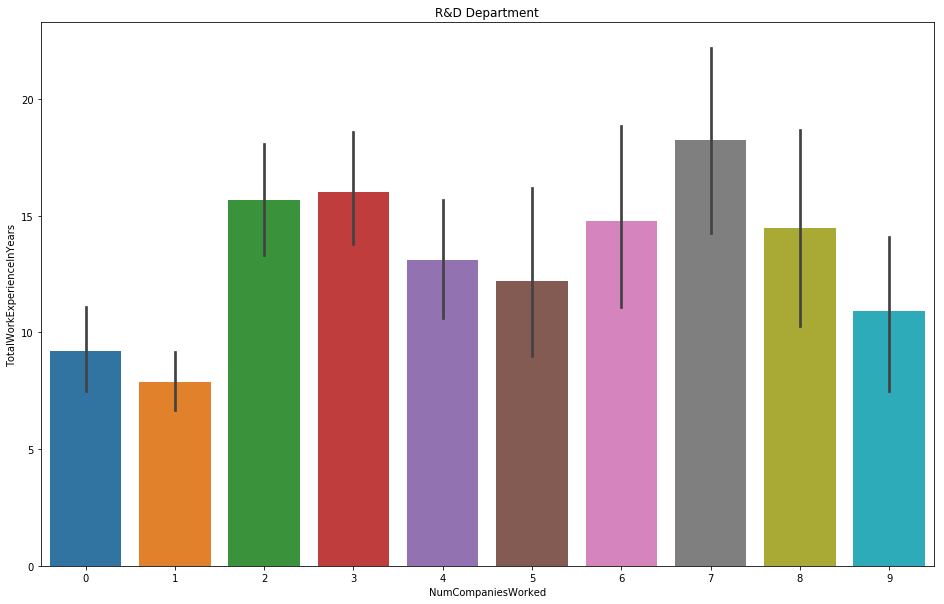

In [75]:
fig=plt.figure(figsize=(16,10))
sns.barplot(rd.NumCompaniesWorked,rd.TotalWorkExperienceInYears);
plt.title('R&D Department')

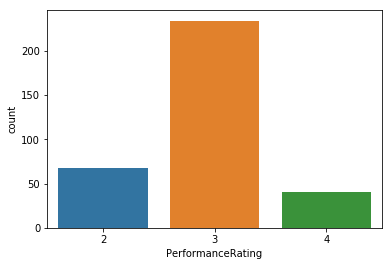

In [62]:
sns.countplot(rd.PerformanceRating);

Text(0.5, 1.0, 'Data Science Department')

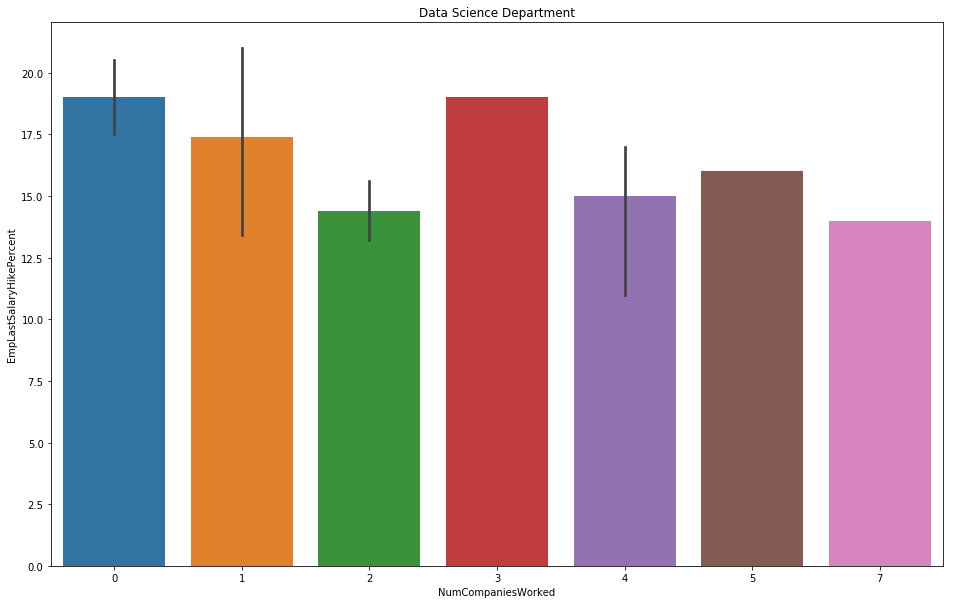

In [76]:
fig=plt.figure(figsize=(16,10))
sns.barplot(ds.NumCompaniesWorked,ds.EmpLastSalaryHikePercent);
plt.title('Data Science Department')

Text(0.5, 1.0, 'Finance Department')

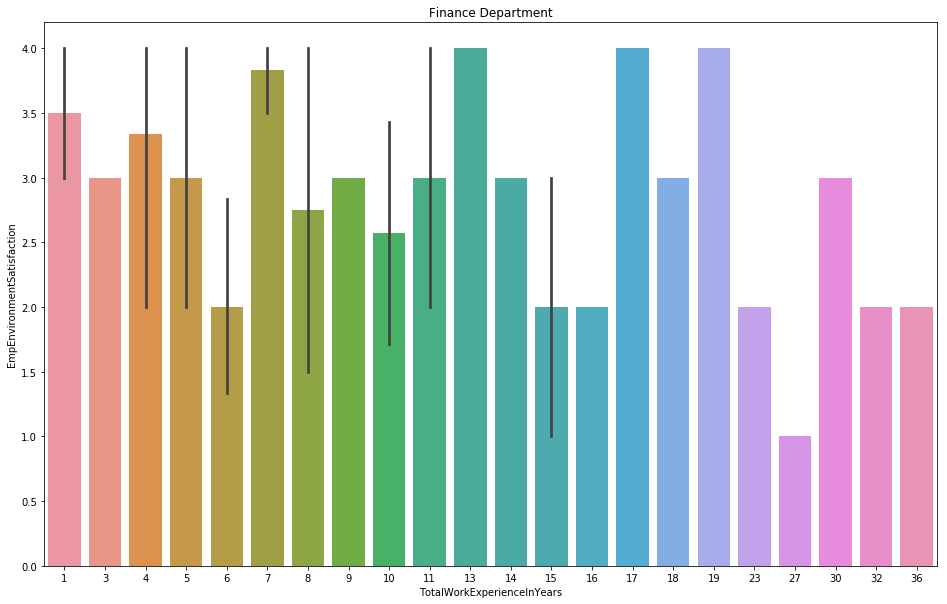

In [77]:
fig=plt.figure(figsize=(16,10))

sns.barplot(finance.TotalWorkExperienceInYears,finance.EmpEnvironmentSatisfaction);
plt.title('Finance Department')

### Outlier Analysis of the above features

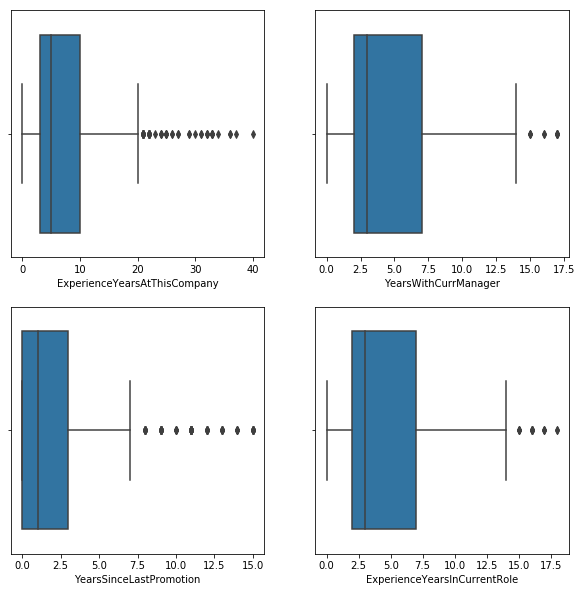

In [11]:
fig,ax=plt.subplots(2,2 ,figsize=(10,10))
sns.boxplot(data['ExperienceYearsAtThisCompany'],ax=ax[0,0]);
sns.boxplot(data['YearsWithCurrManager'],ax=ax[0,1]);
sns.boxplot(data['YearsSinceLastPromotion'],ax=ax[1,0]);
sns.boxplot(data['ExperienceYearsInCurrentRole'],ax=ax[1,1]);
plt.show()

### As the dataset is small we have to impute the outliers.

In [12]:
data.loc[data.ExperienceYearsAtThisCompany>40,'ExperienceYearsAtThisCompany'] = np.nan
data.fillna(data.mean(), inplace=True)

data.loc[data.YearsWithCurrManager>16,'YearsWithCurrManager'] = np.nan
data.fillna(data.mean(), inplace=True)

data.loc[data.YearsSinceLastPromotion>15,'YearsSinceLastPromotion'] = np.nan
data.fillna(data.mean(), inplace=True)

data.loc[data.ExperienceYearsInCurrentRole>17,'ExperienceYearsInCurrentRole'] = np.nan
data.fillna(data.mean(), inplace=True)


### The output feature is imbalanced which will bias our model to the most occuring value so we have to balance the dataset

In [13]:
Counter(y)

Counter({3: 874, 4: 132, 2: 194})

### We are using 8 Label Encoders instead of loop to identify the classes of the features, if we run a loop the classes cannot be w.r.t to features.

In [14]:
le1= LabelEncoder()
le2= LabelEncoder()
le3= LabelEncoder()
le4= LabelEncoder()
le5= LabelEncoder()
le6= LabelEncoder()
le7 = LabelEncoder()
le8 = LabelEncoder()

X.EducationBackground=le1.fit_transform(X.EducationBackground)
X.MaritalStatus=le2.fit_transform(X.MaritalStatus)
X.EmpDepartment=le3.fit_transform(X.EmpDepartment)
X.EmpJobRole=le4.fit_transform(X.EmpJobRole)
X.BusinessTravelFrequency=le5.fit_transform(X.BusinessTravelFrequency)
X.Attrition=le6.fit_transform(X.Attrition)
X.OverTime = le7.fit_transform(X.OverTime)
X.Gender = le8.fit_transform(X.Gender)

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=10)
model_rf=RandomForestClassifier(n_estimators=40,criterion='gini',max_depth=12)
model_rf.fit(X_train,y_train)
y_pred = model_rf.predict(X_test)

# With cross val score

scores = cross_val_score(model_rf,X,y,cv=5,scoring='accuracy')

parameters = {'max_depth':[5,10,15],
              'random_state': range(0,4),
              'n_estimators':[10,15,20,40,100], 
             }
grid = GridSearchCV(RandomForestClassifier(),parameters)
grid.fit(X_train,y_train)
print('The Accuracy Score is:',accuracy_score(y_test,y_pred))
print('The Scores of different folds are : ',scores)
print('The Mean Score of folds are : ',scores.mean())
print('The best Grid Score is : ',grid.best_score_)
print('The best Parameters are : ',grid.best_params_)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


The Accuracy Score is: 0.9233333333333333
The Scores of different folds are :  [0.90871369 0.95850622 0.97916667 0.90416667 0.88655462]
The Mean Score of folds are :  0.9274215744389043
The best Grid Score is :  0.9355555555555556
The best Parameters are :  {'max_depth': 15, 'n_estimators': 100, 'random_state': 1}


### With SMOTE

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify=y)
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)
model_rfsmt = RandomForestClassifier()
model_rfsmt.fit(X_train, y_train)
y_pred = model_rfsmt.predict(X_test)
# With cross val score
scores = cross_val_score(model_rf,X,y,cv=5,scoring='accuracy')
parameters = {'max_depth':[5,10,15],
              'random_state': range(0,4),
              'n_estimators':[10,15,20,40,100], 
             }
grid = GridSearchCV(RandomForestClassifier(),parameters)
grid.fit(X_train,y_train)
print('The Accuracy Score is:',accuracy_score(y_test,y_pred))
print('The Scores of different folds are : ',scores)
print('The Mean Score of folds are : ',scores.mean())
print('The Best Grid Score is : ',grid.best_score_)
print('The Best Parameters are : ',grid.best_params_)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


The Accuracy Score is: 0.8833333333333333
The Scores of different folds are :  [0.91286307 0.95435685 0.97083333 0.9        0.89915966]
The Mean Score of folds are :  0.9274425828422656
The Best Grid Score is :  0.956234096692112
The Best Parameters are :  {'max_depth': 10, 'n_estimators': 100, 'random_state': 1}


In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.25,random_state=10)
model_xg=XGBClassifier(max_depth=12)
model_xg.fit(X_train,y_train)
y_pred = model_xg.predict(X_test)
scores = cross_val_score(model_xg,X,y,cv=5,scoring='accuracy')
print('The Accuracy Score is:',accuracy_score(y_test,y_pred))
print('The Scores of different folds are : ',scores)
print('The Mean Score of folds are : ',scores.mean())

The Accuracy Score is: 0.9266666666666666
The Scores of different folds are :  [0.91286307 0.93775934 0.98333333 0.90416667 0.90756303]
The Mean Score of folds are :  0.9291370863698176
